In [3]:


import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

import trompy as tp



# the next two lines will expand the printed tables
pd.options.display.max_rows= 40000
pd.options.display.max_columns= 40000

In [ ]:
pd.read_excel(r"C:\Users\hta031\Github\FEDPROTEINPRO\METAFILE FEDXC DATA SHEETS.xls" ,sheet_name="METAFILE" )

#pd.read_csv(r"C:\Users\hta031\Github\FEDPROTEINPRO\data\FED004_091022_00.CSV")



In [4]:
DATA_FOLDER = "..\\data"
df = pd.read_csv(os.path.join(DATA_FOLDER, "FED001_091022_00.CSV"))

def tweak_fed(df):
    
    return (df
             .rename(columns={"MM:DD:YYYY hh:mm:ss": "t",
                             "InterPelletInterval": "ipi"})
             .assign(t=lambda df_: pd.to_datetime(df_.t))
             .set_index("t")
             .query("Event == 'Pellet'")
             .loc[:,"ipi"] # could use .loc[:,["ipi", "col2", "col5" etc]] to get mutliple columns, e.g. animal name etc
           )
#tweak_fed(df) # could add animal name from metafile and diet and phase so these are returned in dataframe

In [5]:
# read in metafile and put pellets dataframe in keys of a dict
METAFILE = "..\\METAFILE FEDXC DATA SHEETS.xls"
rows, header = tp.metafilereader(METAFILE, sheetname="METAFILE")

ff_dict = {}
for row in rows:
    # file, mouse, diet, mode, sex,order,epoch = row
    fedfile, mouse, diet, mode, sex,order,epoch = row
    if (mode == "FF") and (diet in ["NR", "PR"]):
        key = "_".join([mouse, epoch])
        ff_dict[key] = {}
        ff_dict[key]["mouse"] = mouse
        ff_dict[key]["diet"] = diet
        ff_dict[key]["sex"] = sex
        ff_dict[key]["epoch"] = epoch
        ff_dict[key]["order"] = int(order)
        ff_dict[key]["pellets"] = tweak_fed(pd.read_csv(os.path.join(DATA_FOLDER, fedfile)))
    


File is excel file. Making csv metafile first


In [6]:
ff_dict["FEDXC01_E1"]["pellets"].head(20)


t
2022-09-10 08:57:16      NaN
2022-09-10 09:00:18    182.0
2022-09-10 09:02:20    122.0
2022-09-10 09:03:01     41.0
2022-09-10 09:03:18     17.0
2022-09-10 09:03:44     26.0
2022-09-10 09:12:39    535.0
2022-09-10 09:13:30     51.0
2022-09-10 09:13:54     24.0
2022-09-10 09:20:51    417.0
2022-09-10 09:21:07     16.0
2022-09-10 09:21:23     16.0
2022-09-10 09:23:17    114.0
2022-09-10 09:24:04     47.0
2022-09-10 09:30:51    407.0
2022-09-10 09:32:41    110.0
2022-09-10 09:32:59     18.0
2022-09-10 09:33:08      9.0
2022-09-10 09:37:28    260.0
2022-09-10 09:37:43     15.0
Name: ipi, dtype: float64

In [7]:
(ff_dict["FEDXC01_E1"]["pellets"]
 .resample("d")
 .count()
)

t
2022-09-10    160
2022-09-11    152
2022-09-12    153
2022-09-13    144
2022-09-14    141
2022-09-15    159
2022-09-16    167
2022-09-17    162
2022-09-18    167
2022-09-19     73
Freq: D, Name: ipi, dtype: int64

In [8]:
mice=[]
for key in ff_dict.keys():
    
    mouse= key.split("_")[0]
    if mouse not in mice:
        mice.append(mouse)

In [9]:
ff_dict_all_epochs={}
for mouse in mice:
    ff_dict_all_epochs[mouse]={}
    temp=[]
    for key, val in ff_dict.items():
        if mouse in key:
            temp.append(val["pellets"])
            ff_dict_all_epochs [mouse]["order"]= val["order"]
            
    ff_dict_all_epochs[mouse]["pellets"]=pd.concat(temp)       

In [10]:
ff_dict_all_epochs["FEDXC01"]["pellets"].head(50)

t
2022-09-10 08:57:16       NaN
2022-09-10 09:00:18     182.0
2022-09-10 09:02:20     122.0
2022-09-10 09:03:01      41.0
2022-09-10 09:03:18      17.0
2022-09-10 09:03:44      26.0
2022-09-10 09:12:39     535.0
2022-09-10 09:13:30      51.0
2022-09-10 09:13:54      24.0
2022-09-10 09:20:51     417.0
2022-09-10 09:21:07      16.0
2022-09-10 09:21:23      16.0
2022-09-10 09:23:17     114.0
2022-09-10 09:24:04      47.0
2022-09-10 09:30:51     407.0
2022-09-10 09:32:41     110.0
2022-09-10 09:32:59      18.0
2022-09-10 09:33:08       9.0
2022-09-10 09:37:28     260.0
2022-09-10 09:37:43      15.0
2022-09-10 09:38:24      41.0
2022-09-10 09:39:05      41.0
2022-09-10 09:39:26      21.0
2022-09-10 09:47:58     512.0
2022-09-10 09:51:37     219.0
2022-09-10 09:51:52      15.0
2022-09-10 09:52:16      24.0
2022-09-10 09:52:56      40.0
2022-09-10 09:54:03      67.0
2022-09-10 09:54:19      16.0
2022-09-10 10:00:05     346.0
2022-09-10 10:02:34     149.0
2022-09-10 10:02:51      17.0
2022-09-

In [131]:
ff_dict_all_epochs["FEDXC01"]["pellets"]

#I chnage the offset from 9H to 8H since the code was working in a weird manner and reading date from a day before the experiment begins!

def pellets_by_day(df,maxdays=30):
    return (df
            .rename(index="n_pellets")
            .resample("d", offset = "8H")
            .count()
            .head(maxdays)#We need to add the final two rows instead of deleting last row 
            #.reset_index()
            
           )
pellets_by_day(ff_dict_all_epochs["FEDXC01"]["pellets"])


#The original code by Jaime
# NR=[]
# PR=[]
# for key, val in ff_dict_all_epochs.items():
#     if val["order"] == 1:
#         NR.append(pellets_by_day(val["pellets"]))
#     elif val["order"] == 2:
#         PR.append(pellets_by_day(val["pellets"]))



# NR= pd.concat(NR, axis=1)
# PR= pd.concat(PR, axis=1)



#The code we developed in the second edition
ctl=[]
exp=[]
for key, val in ff_dict_all_epochs.items():
    if val["order"] == 1:
        ctl.append(pellets_by_day(val["pellets"]))
    elif val["order"] == 2:
        exp.append(pellets_by_day(val["pellets"]))

        
# this line will take the mean value of a column to be replaced with NAn or 0, "meanvalue" should be placed
#in .fillna(meanvalue)
#meanvalue = exp_pellets["n_pellets"].mean()
        
        

def clean_df(lst):
    return (pd.concat(lst, axis= 1)
           .fillna(0)
           .head(23)) #23 days used because in epoch 4 we used expired pellets for ctl animals

    
  
#Removing the first two rows of the data, since it represents the training days

ctl_pellets= clean_df(ctl).iloc[2:]
exp_pellets= clean_df(exp).iloc[2:]
#We need to add the final two rows instead of deleting last row
#why one of the animals is starting a day later the others??




In [133]:
#prints pellet intake excluding the first 2 days of training and epoch 4
ctl_pellets

,n_pellets,n_pellets,n_pellets,n_pellets,n_pellets,n_pellets
t,,,,,,
2022-09-12 08:00:00,201,172,169,194,173,192
2022-09-13 08:00:00,173,169,176,183,179,184
2022-09-14 08:00:00,183,188,195,191,184,201
2022-09-15 08:00:00,190,195,187,202,213,197
2022-09-16 08:00:00,161,187,172,192,193,207
2022-09-17 08:00:00,182,191,178,203,181,220
2022-09-18 08:00:00,165,188,176,173,170,179
2022-09-19 08:00:00,187,177,182,182,187,187
2022-09-20 08:00:00,179,173,184,211,178,191


In [127]:

# NR.to_csv(r"C:\Users\hta031\Github\FEDPROTEINPRO\STATS_FEDPROTEINPRO\NRresult.csv")

# PR.to_csv(r"C:\Users\hta031\Github\FEDPROTEINPRO\STATS_FEDPROTEINPRO\PRresult.csv")



In [128]:
# NR.mean(axis=1)
# PR.mean(axis=1)

# f, ax = plt.subplots()
# ax.plot(NR.mean(axis=1),) #yerror= NR.sem(axis=1))
# ax.plot(PR.mean(axis=1))

C:\Users\admin\AppData\Local\Temp\ipykernel_19808\3173618334.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)


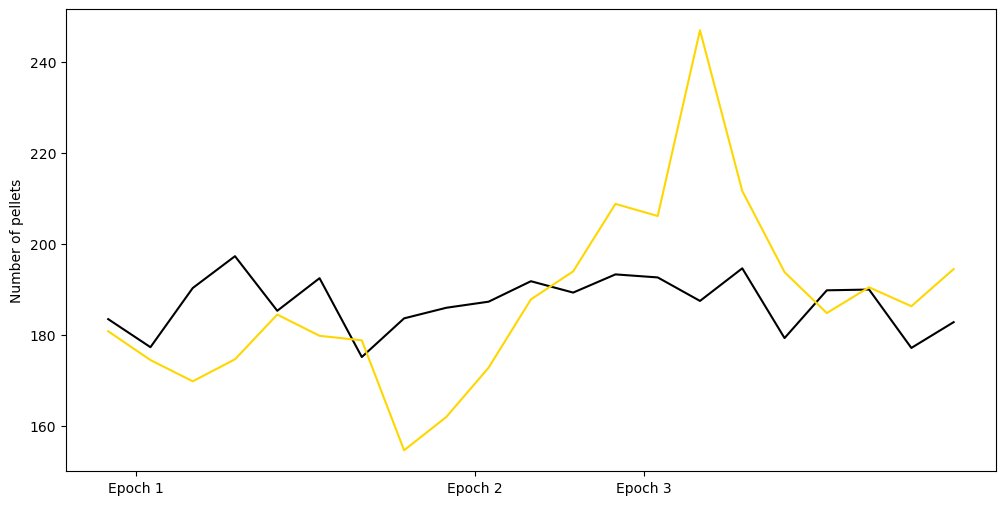

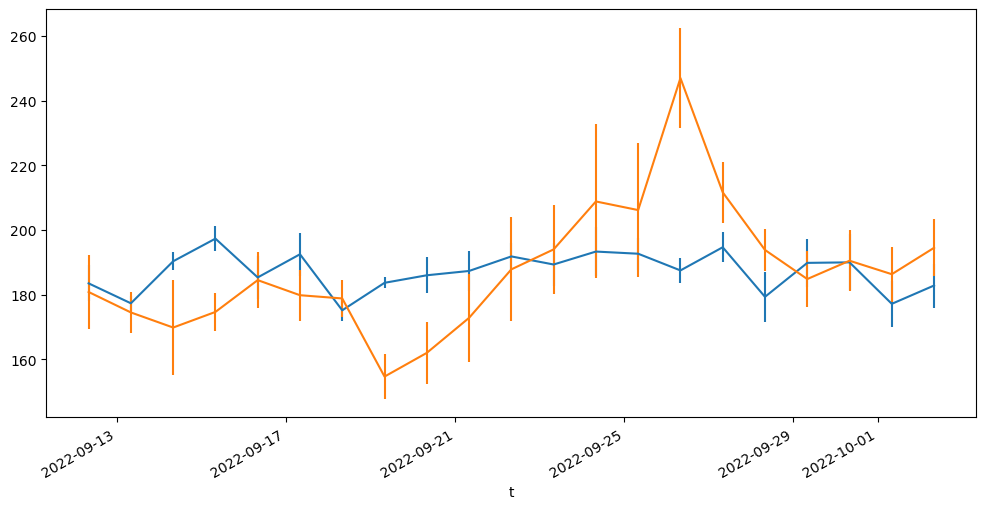

In [145]:
f, ax = plt.subplots(figsize=(12,6) )
ax.plot(ctl_pellets.mean(axis=1),color="black") #yerror= NR.sem(axis=1))
ax.plot(exp_pellets.mean(axis=1), color= "gold")
ax.set_ylabel("Number of pellets")
# ax.set_xlabel("Days")

#trying to get correct xticks for each epoch
labels = [item.get_text() for item in ax.get_xticklabels()]
labels[0] = "Epoch 1"
labels[2] = "Epoch 2"
labels[3] = "Epoch 3"

#trying to remove unwanted ticks
xticks = ax.xaxis.get_major_ticks()
xticks[1].set_visible(False)
xticks[4].set_visible(False)
xticks[5].set_visible(False)

ax.set_xticklabels(labels)

plt.show()




f, ax = plt.subplots(figsize=(12,6) )
ctl_pellets.mean(axis=1).plot(yerr= ctl_pellets.sem(axis=1), ax=ax)
exp_pellets.mean(axis=1).plot(yerr= exp_pellets.sem(axis=1), ax=ax)

# from matplotlib import ticker

# ticker.IndexLocator(  offset=7)
# ticker.MaxNLocator(3)
#ax.set_xticks([0,1,2])


C:\Users\admin\AppData\Local\Temp\ipykernel_19808\3930830357.py:78: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)


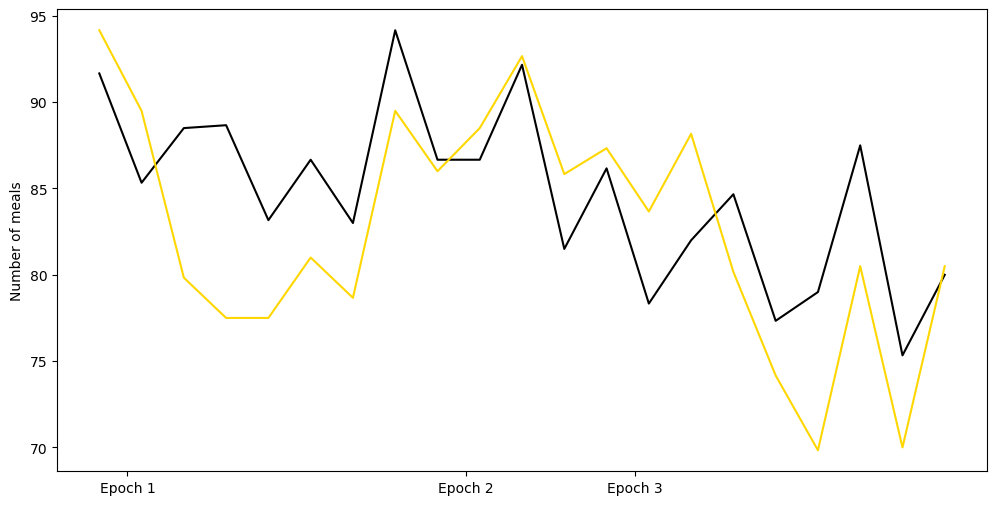

<AxesSubplot:xlabel='t'>

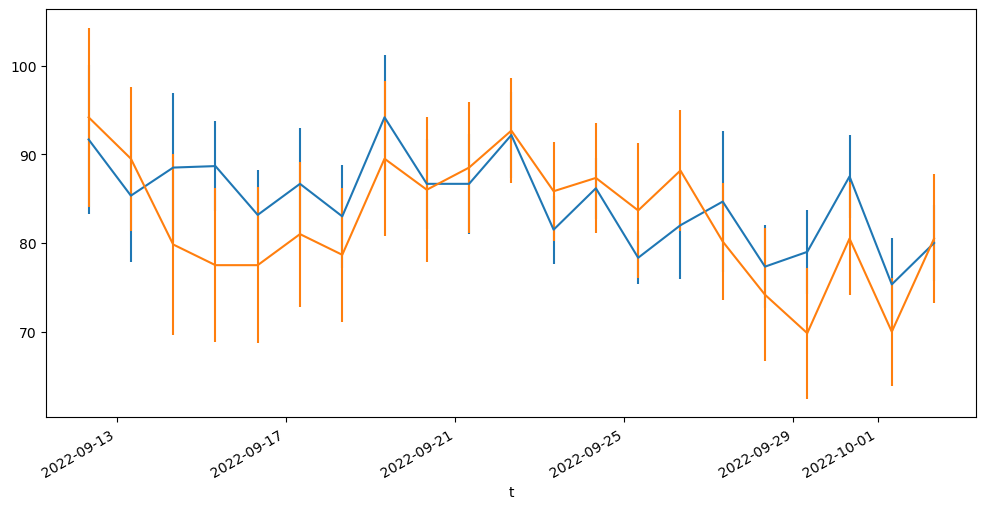

In [147]:
# ff_dict_all_epochs["FEDXC01"]["pellets"]

# # def calculate_meals(df):
# #     return (df
            
        
# def nmeals_by_day(df):
#     return (df
#             .resample("d", offset = "10H")
#             .apply(lambda df_: sum(df_ > 60))
#             .reset_index()
            
#            )
# nmeals_by_day (ff_dict_all_epochs["FEDXC01"]["pellets"])


# def mealsize_by_day(df):
#     return (df
#             .resample("d", offset = "10H")
#             .apply(lambda df_: df_.count()/sum(df_ > 60))
#             .reset_index()
            
#            )
# mealsize_by_day (ff_dict_all_epochs["FEDXC01"]["pellets"])

# ff_dict_all_epochs["FEDXC01"]["pellets"]

# def calculate_meals(df):
#     return (df

###########################################NEW VERSION OF THE CODE#########################

            
        
def nmeals_by_day(df):
    return (df
             .rename(index="n_meals")
            .resample("d", offset = "8H")
            .apply(lambda df_: sum(df_ > 60))
            # .reset_index()
            
           )

ctl=[]
exp=[]
for key, val in ff_dict_all_epochs.items():
    if val["order"] == 1:
        ctl.append(nmeals_by_day(val["pellets"]))
    elif val["order"] == 2:
        exp.append(nmeals_by_day(val["pellets"]))

ctl_n_meals= clean_df(ctl).iloc[2:]

exp_n_meals= clean_df(exp).iloc[2:]





f, ax = plt.subplots(figsize=(12,6) )
ax.plot(ctl_n_meals.mean(axis=1),color="black") #yerror= NR.sem(axis=1))
ax.plot(exp_n_meals.mean(axis=1), color= "gold")
ax.set_ylabel("Number of meals")
# ax.set_xlabel("Days")

#trying to get correct xticks for each epoch
labels = [item.get_text() for item in ax.get_xticklabels()]
labels[0] = "Epoch 1"
labels[2] = "Epoch 2"
labels[3] = "Epoch 3"

#trying to remove unwanted ticks
xticks = ax.xaxis.get_major_ticks()
xticks[1].set_visible(False)
xticks[4].set_visible(False)
xticks[5].set_visible(False)

ax.set_xticklabels(labels)

plt.show()




f, ax = plt.subplots(figsize=(12,6))
ctl_n_meals.mean(axis=1).plot(yerr= ctl_n_meals.sem(axis=1), ax=ax)
exp_n_meals.mean(axis=1).plot(yerr= exp_n_meals.sem(axis=1), ax=ax)


In [139]:
# ff_dict_all_epochs["FEDXC01"]["pellets"]

# def pellets_by_day(df):
#     return (df
#             .between_time("9:0", "7:0")
#             .resample("d", offset = "9H")
#             .count()
#             #.reset_index()
            
#            )

# pellets_by_day(ff_dict_all_epochs["FEDXC01"]["pellets"])

# NR=[]
# PR=[]
# for key, val in ff_dict_all_epochs.items():
#     if val["order"] == 1:
#         NR.append(pellets_by_day(val["pellets"]))
#     elif val["order"] == 2:
#         PR.append(pellets_by_day(val["pellets"]))
    
    


# NR= pd.concat(NR, axis=1)
# PR= pd.concat(PR, axis=1)


# f, ax = plt.subplots()
# NR.mean(axis=1).plot(yerr= NR.sem(axis=1), ax=ax)
# PR.mean(axis=1).plot(yerr= PR.sem(axis=1), ax=ax)
# #ax.set_xticks([0,1,2])

C:\Users\admin\AppData\Local\Temp\ipykernel_19808\2683778822.py:5: RuntimeWarning: invalid value encountered in longlong_scalars
  .apply(lambda df_: df_.count()/sum(df_ > 60))
C:\Users\admin\AppData\Local\Temp\ipykernel_19808\2683778822.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)


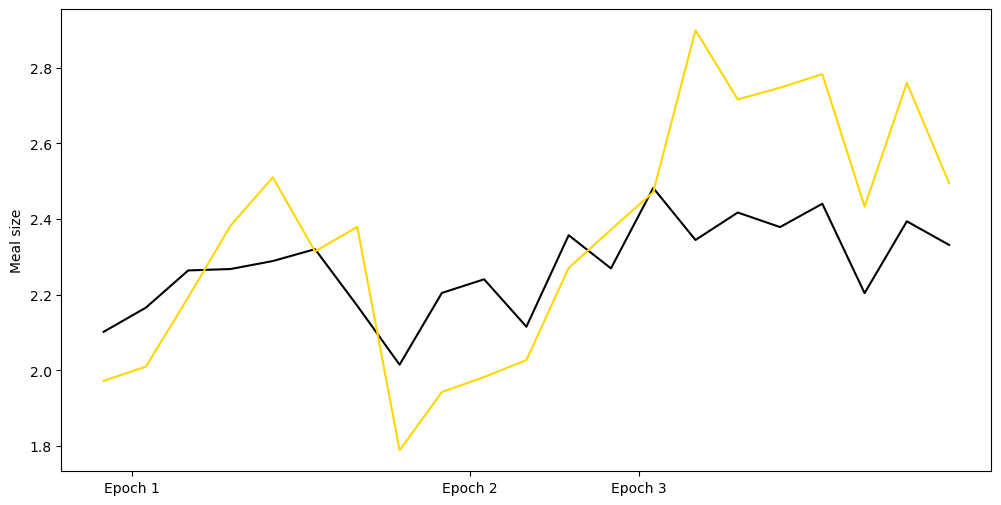

<AxesSubplot:xlabel='t'>

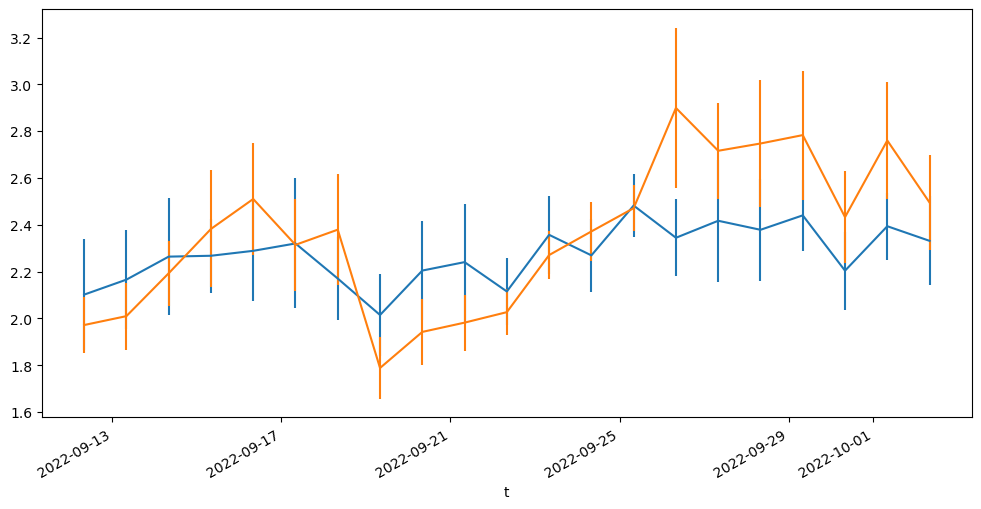

In [154]:
def mealsize_by_day(df):
    return (df
            .rename(index="mealsize")
            .resample("d", offset = "8H")
            .apply(lambda df_: df_.count()/sum(df_ > 60))
            
#              .reset_index()
            
           )
#mealsize_by_day (ff_dict_all_epochs["FEDXC01"]["pellets"])


ctl=[]
exp=[]
for key, val in ff_dict_all_epochs.items():
    if val["order"] == 1:
        ctl.append(mealsize_by_day(val["pellets"]))
    elif val["order"] == 2:
        exp.append(mealsize_by_day(val["pellets"]))

ctl_meal_size= clean_df(ctl).iloc[2:]

exp_meal_size= clean_df(exp).iloc[2:]


f, ax = plt.subplots(figsize=(12,6) )
ax.plot(ctl_meal_size.mean(axis=1),color="black") #yerror= NR.sem(axis=1))
ax.plot(exp_meal_size.mean(axis=1), color= "gold")
ax.set_ylabel("Meal size")
# ax.set_xlabel("Days")

#trying to get correct xticks for each epoch
labels = [item.get_text() for item in ax.get_xticklabels()]
labels[0] = "Epoch 1"
labels[2] = "Epoch 2"
labels[3] = "Epoch 3"

#trying to remove unwanted ticks
xticks = ax.xaxis.get_major_ticks()
xticks[1].set_visible(False)
xticks[4].set_visible(False)
xticks[5].set_visible(False)

ax.set_xticklabels(labels)

plt.show()


f, ax = plt.subplots(figsize=(12,6))
ctl_meal_size.mean(axis=1).plot(yerr= ctl_meal_size.sem(axis=1), ax=ax)
exp_meal_size.mean(axis=1).plot(yerr= exp_meal_size.sem(axis=1), ax=ax)

In [156]:
def make_ff_df(df, mouse, diet,order, epoch):
    """
    Takes df of pellets - time and IPIs - and returns row for collated df
    """
    out = pd.DataFrame.from_dict({"mouse": [mouse],
                                  "diet": [diet],
                                  "order" : [int(order)],
                                  "epoch" : [epoch],
                                   
                                  "n_pellets": [len(df)],
                                  "n_meals": (df > 60).sum(),
                                  "session_time": (df.index[-1] - df.index[0]).total_seconds() / 60,
                                  "short_ipis": (df < 5).sum()
                                  })

    return (out
           .assign(meal_freq=lambda df_: 1 / (df_.session_time / df_.n_meals) * 60 * 24,
                   meal_size=lambda df_: df_.n_pellets / df_.n_meals,
                   )
           .astype({"diet": "category",
                    "n_pellets": "uint16",
                    "n_meals": "uint16"}))

ff = pd.DataFrame()

for key, val in ff_dict.items():
    
    pellets = val["pellets"]
    mouse = val["mouse"]
    diet = val["diet"]
    order = val ["order"]
    epoch = val ["epoch"]
    ff = pd.concat([ff, make_ff_df(pellets, mouse, diet,order, epoch)])
    
ff.reset_index(drop=True, inplace=True);

 #ff_dict[key]["order"] = int(order)


In [158]:
# resultallpellets = pd.concat(frames)
# resultallpellets
# resultallpellets["Mouse"] = resultallpellets.index
ff.to_csv(r"C:\Users\hta031\Github\FEDPROTEINPRO\STATS_FEDPROTEINPRO\\ff.csv")



ff

,mouse,diet,order,epoch,n_pellets,n_meals,session_time,short_ipis,meal_freq,meal_size
0,FEDXC01,NR,2,E1,1479,545,12947.350000,0,60.614720,2.713761
1,FEDXC01,PR,2,E2,1083,469,10074.316667,0,67.037797,2.309168
2,FEDXC01,NR,2,E3,1279,364,10076.800000,0,52.016513,3.513736
3,FEDXC01,PR,2,E4,1051,472,10004.750000,0,67.935731,2.226695
4,FEDXC02,NR,2,E1,1799,824,12927.316667,0,91.787030,2.183252
5,FEDXC02,PR,2,E2,1227,659,10066.550000,0,94.268642,1.861912
6,FEDXC02,NR,2,E3,1333,556,10075.400000,0,79.464835,2.397482
7,FEDXC02,PR,2,E4,1261,689,10013.383333,0,99.083393,1.830189
8,FEDXC03,NR,2,E1,1566,833,12935.433333,0,92.731335,1.879952
9,FEDXC03,PR,2,E2,1233,626,10042.650000,0,89.761169,1.969649


C:\ProgramData\Anaconda3\lib\site-packages\trompy\barscatter.py:304: UserWarning: linewuidth is not a functional keyword argument. Check spelling or barscatter version.
  warnings.warn("{} is not a functional keyword argument. Check spelling or barscatter version.".format(key))


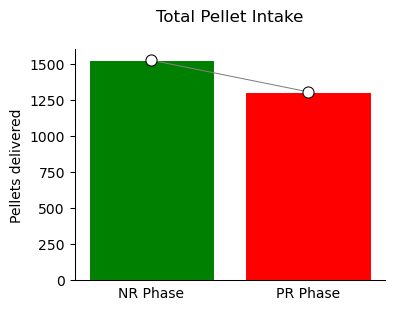

In [24]:
#plots all the pellets taken in PR and NR phases (combined) of Experimental group.
#DATA4LIST = data ["Time spent sitting still"].tolist()



EXP_Pellets = ff.loc[ff["order"] == 2]
EXP_Pellets

EXP_Pellets_PR = EXP_Pellets.loc[EXP_Pellets["diet"] == "PR", ["n_pellets"]].mean()
DATA1 = EXP_Pellets_PR.tolist()


EXP_Pellets_NR= EXP_Pellets.loc[EXP_Pellets["diet"] == "NR", ["n_pellets"]].mean()
DATA2 = EXP_Pellets_NR.tolist()

EXP_Pellets_NR
EXP_Pellets_PR


# def Average (lst):
#     return sum(lst)/len(lst)


f, ax = plt.subplots(figsize= (4, 3))
_, _, barlist, _ = tp.barscatter([DATA2,DATA1], ax=ax, paired=True,linewuidth =1, groupwidth = 0.70,
barfacecolor_option="individual", baredgecolor= ["white"]*8, barfacecolor=["green", "red"],
barlabels = ["NR Phase", "PR Phase"] )

ax.set_title("Total Pellet Intake", pad= 20)
ax.set_ylabel("Pellets delivered",fontsize = 10)

figfolder = r"C:\Users\hta031\OneDrive - UiT Office 365\Documents\People\Hamid\Presentations\2023\08_August\EBBS\EBBS_FIGS\\"
f.savefig(figfolder + "TOTAL_INTAKE_EXP.pdf")


C:\ProgramData\Anaconda3\lib\site-packages\trompy\barscatter.py:304: UserWarning: linewuidth is not a functional keyword argument. Check spelling or barscatter version.
  warnings.warn("{} is not a functional keyword argument. Check spelling or barscatter version.".format(key))


Text(0, 0.5, 'Number of meals')

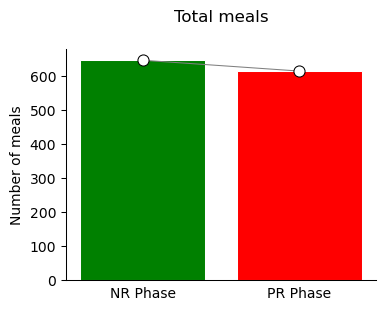

In [21]:
EXP_meal = ff.loc[ff["order"] == 2]
EXP_Pellets

EXP_meal_PR = EXP_Pellets.loc[EXP_Pellets["diet"] == "PR", ["n_meals"]].mean()


EXP_meal_NR= EXP_Pellets.loc[EXP_Pellets["diet"] == "NR", ["n_meals"]].mean()




# def Average (lst):
#     return sum(lst)/len(lst)


f, ax = plt.subplots(figsize= (4, 3))
_, _, barlist, _ = tp.barscatter([EXP_meal_NR,EXP_meal_PR], ax=ax, paired=True,linewuidth =1, groupwidth = 0.70,
barfacecolor_option="individual", baredgecolor= ["white"]*8, barfacecolor=["green", "red"],
barlabels = ["NR Phase", "PR Phase"] )

ax.set_title("Total meals", pad= 20)
ax.set_ylabel("Number of meals",fontsize = 10)

C:\ProgramData\Anaconda3\lib\site-packages\trompy\barscatter.py:304: UserWarning: linewuidth is not a functional keyword argument. Check spelling or barscatter version.
  warnings.warn("{} is not a functional keyword argument. Check spelling or barscatter version.".format(key))


Text(0, 0.5, 'Number of meals/day')

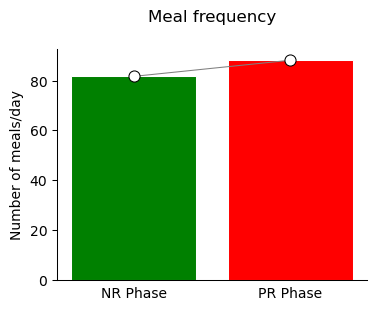

In [22]:
EXP_meal = ff.loc[ff["order"] == 2]


EXP_mealfreq_PR = EXP_Pellets.loc[EXP_Pellets["diet"] == "PR", ["meal_freq"]].mean()


EXP_mealfreq_NR= EXP_Pellets.loc[EXP_Pellets["diet"] == "NR", ["meal_freq"]].mean()




# def Average (lst):
#     return sum(lst)/len(lst)


f, ax = plt.subplots(figsize= (4, 3))
_, _, barlist, _ = tp.barscatter([EXP_mealfreq_NR,EXP_mealfreq_PR], ax=ax, paired=True,linewuidth =1, groupwidth = 0.70,
barfacecolor_option="individual", baredgecolor= ["white"]*8, barfacecolor=["green", "red"],
barlabels = ["NR Phase", "PR Phase"] )

ax.set_title("Meal frequency", pad= 20)
ax.set_ylabel("Number of meals/day",fontsize = 10)

C:\ProgramData\Anaconda3\lib\site-packages\trompy\barscatter.py:304: UserWarning: linewuidth is not a functional keyword argument. Check spelling or barscatter version.
  warnings.warn("{} is not a functional keyword argument. Check spelling or barscatter version.".format(key))


Text(0, 0.5, 'Number of pellets/meal')

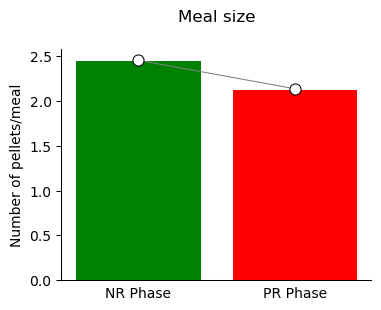

In [23]:
EXP_meal = ff.loc[ff["order"] == 2]


EXP_mealsize_PR = EXP_Pellets.loc[EXP_Pellets["diet"] == "PR", ["meal_size"]].mean()


EXP_mealsize_NR= EXP_Pellets.loc[EXP_Pellets["diet"] == "NR", ["meal_size"]].mean()




# def Average (lst):
#     return sum(lst)/len(lst)


f, ax = plt.subplots(figsize= (4, 3))
_, _, barlist, _ = tp.barscatter([EXP_mealsize_NR,EXP_mealsize_PR], ax=ax, paired=True,linewuidth =1, groupwidth = 0.70,
barfacecolor_option="individual", baredgecolor= ["white"]*8, barfacecolor=["green", "red"],
barlabels = ["NR Phase", "PR Phase"] )

ax.set_title("Meal size", pad= 20)
ax.set_ylabel("Number of pellets/meal",fontsize = 10)

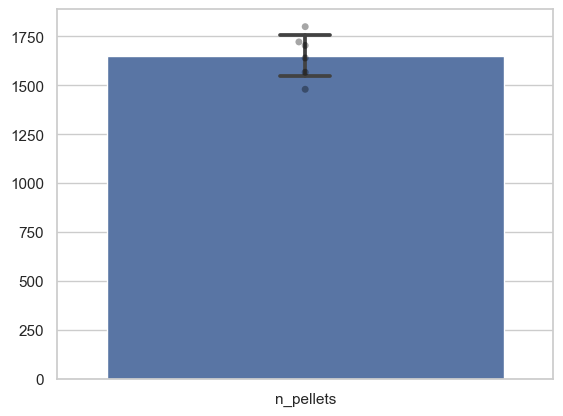

In [69]:
#this cell plots total pellet intake of only Protein restricted mice in 4 epochs NR, PR,NR,PR


EXP_Pellets = ff.loc[ff["order"] == 2]
# CTL_Pellets= ff.loc[ff["order"] == 1]



EXP_Pellets_E1_NR = EXP_Pellets.loc[EXP_Pellets["epoch"] == "E1", ["n_pellets"]]
EXPE1=[EXP_Pellets_E1_NR ]

# CTL_Pellets_E1_NR = CTL_Pellets.loc[CTL_Pellets["epoch"] == "E1", ["n_pellets"]].mean()

EXP_Pellets_E2_PR = EXP_Pellets.loc[EXP_Pellets["epoch"] == "E2", ["n_pellets"]]
EXPE2=[EXP_Pellets_E2_PR ]
# CTL_Pellets_E2_NR = CTL_Pellets.loc[CTL_Pellets["epoch"] == "E2", ["n_pellets"]].mean()

EXP_Pellets_E3_NR = EXP_Pellets.loc[EXP_Pellets["epoch"] == "E3", ["n_pellets"]]
EXPE3=[EXP_Pellets_E3_NR ]
# CTL_Pellets_E3_NR = CTL_Pellets.loc[CTL_Pellets["epoch"] == "E3", ["n_pellets"]].mean()

EXP_Pellets_E4_PR = EXP_Pellets.loc[EXP_Pellets["epoch"] == "E4", ["n_pellets"]]
EXPE4=[EXP_Pellets_E4_PR ]
# CTL_Pellets_E4_NR = CTL_Pellets.loc[CTL_Pellets["epoch"] == "E4", ["n_pellets"]].mean()

# def Average (lst):
#     return sum(lst)/len(lst)


# f, ax = plt.subplots(figsize= (8, 4))
# _, _, barlist, _ = tp.barscatter([[EXPE1],[EXPE2],[EXPE3],[EXPE4]], ax=ax, paired=True,linewuidth =1, groupwidth = 0.70,
# barfacecolor_option="individual", baredgecolor= ["white"], barfacecolor=["green", "red","green", "red"],
# barlabels = ["NR Phase","PR Phase","NR Phase","PR Phase"] )
# ax.set_title("Total Pellet Intake", pad= 50)






# secax = ax.secondary_xaxis('top', color = "black" )
# secax.set_xlabel( "Epoch 1                    Epoch 2                    Epoch 3                      Epoch 4", labelpad= -14.5)
# secax.tick_params(axis='x', colors='white') 
# secax.spines['top'].set_color('white')
# ax.set_ylabel("Pellets delivered",fontsize = 10)

# ax.axes.secondary_xaxis.set_ticklabels([])
# # secax.yticks([])
# plt.show()
# # secax.set_axis_off()
# for side in ['top','right','bottom','left']:
#     ax.spines[side].set_visible(True)
# secax.tick_params(axis='both',which='both',labelbottom=False,bottom=False,left=False)
# secax.set_yticks([min(y),max(y)]) 



import seaborn as sns, matplotlib.pyplot as plt
sns.set(style="whitegrid")


sns.barplot( data=EXP_Pellets_E1_NR,capsize=.1, ci="sd")
sns.swarmplot( data=EXP_Pellets_E1_NR, color="0", alpha=.35)
# sns.barplot( data=EXP_Pellets_E2_PR, capsize=.1, ci="sd")
# sns.swarmplot( data=EXP_Pellets_E2_PR, color="0", alpha=.35)
# sns.barplot(y="n_pellets", data=EXP_Pellets_E2_PR, capsize=.1, ci="sd")
# sns.swarmplot(y="n_pellets", data=EXP_Pellets_E2_PR, color="0", alpha=.35)
plt.show()

# tips = sns.load_dataset("tips")
# ax = sns.barplot(x="day", y="total_bill", data=tips)



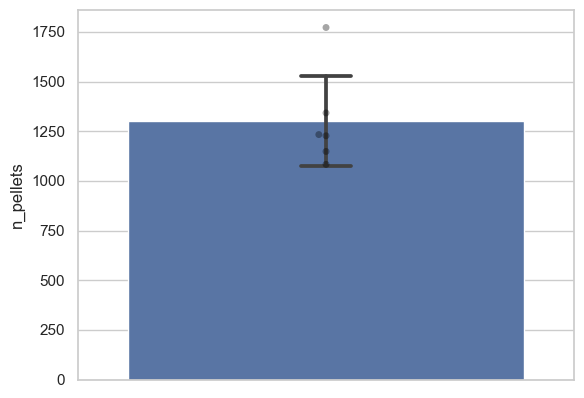

In [60]:
sns.barplot(y="n_pellets", data=EXP_Pellets_E2_PR, capsize=.1, ci="sd")
sns.swarmplot(y="n_pellets", data=EXP_Pellets_E2_PR, color="0", alpha=.35)
plt.show()



In [ ]:
#I am trying to plot the data of each epoch for Experimental (PRNR group) with individual values visible


EXP_Pellets = ff.loc[ff["order"] == 2]
# CTL_Pellets= ff.loc[ff["order"] == 1]



EXP_Pellets_E1_NR = EXP_Pellets.loc[EXP_Pellets["epoch"] == "E1", ["n_pellets"]].mean()

# CTL_Pellets_E1_NR = CTL_Pellets.loc[CTL_Pellets["epoch"] == "E1", ["n_pellets"]].mean()

EXP_Pellets_E2_PR = EXP_Pellets.loc[EXP_Pellets["epoch"] == "E2", ["n_pellets"]].mean()

# CTL_Pellets_E2_NR = CTL_Pellets.loc[CTL_Pellets["epoch"] == "E2", ["n_pellets"]].mean()

EXP_Pellets_E3_NR = EXP_Pellets.loc[EXP_Pellets["epoch"] == "E3", ["n_pellets"]].mean()

# CTL_Pellets_E3_NR = CTL_Pellets.loc[CTL_Pellets["epoch"] == "E3", ["n_pellets"]].mean()

EXP_Pellets_E4_PR = EXP_Pellets.loc[EXP_Pellets["epoch"] == "E4", ["n_pellets"]].mean()

# CTL_Pellets_E4_NR = CTL_Pellets.loc[CTL_Pellets["epoch"] == "E4", ["n_pellets"]].mean()

# def Average (lst):
#     return sum(lst)/len(lst)


f, ax = plt.subplots(figsize= (8, 4))
_, _, barlist, _ = tp.barscatter([EXP_Pellets_E1_NR,EXP_Pellets_E2_PR,EXP_Pellets_E3_NR,EXP_Pellets_E4_PR], ax=ax, paired=True,linewuidth =1, groupwidth = 0.70,
barfacecolor_option="individual", baredgecolor= ["white"], barfacecolor=["green", "red","green", "red"],
barlabels = ["NR Phase","PR Phase","NR Phase","PR Phase"] )
ax.set_title("Total Pellet Intake", pad= 50)






secax = ax.secondary_xaxis('top', color = "black" )
secax.set_xlabel( "Epoch 1                    Epoch 2                    Epoch 3                      Epoch 4", labelpad= -14.5)
secax.tick_params(axis='x', colors='white') 
secax.spines['top'].set_color('white')
ax.set_ylabel("Pellets delivered",fontsize = 10)

# ax.axes.secondary_xaxis.set_ticklabels([])
# # secax.yticks([])
# plt.show()
# # secax.set_axis_off()
# for side in ['top','right','bottom','left']:
#     ax.spines[side].set_visible(True)
# secax.tick_params(axis='both',which='both',labelbottom=False,bottom=False,left=False)
# secax.set_yticks([min(y),max(y)]) 

C:\ProgramData\Anaconda3\lib\site-packages\trompy\barscatter.py:304: UserWarning: linewuidth is not a functional keyword argument. Check spelling or barscatter version.
  warnings.warn("{} is not a functional keyword argument. Check spelling or barscatter version.".format(key))


Text(0, 0.5, 'Total number of meals')

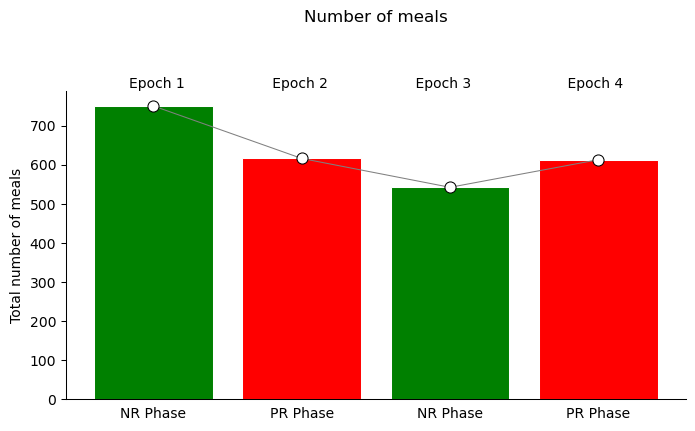

In [33]:
#this cell plots total number of meals of Protein restricted mice in 4 epochs NR, PR,NR,PR


EXP_Pellets = ff.loc[ff["order"] == 2]
# CTL_Pellets= ff.loc[ff["order"] == 1]



EXP_Pellets_E1_NR = EXP_Pellets.loc[EXP_Pellets["epoch"] == "E1", ["n_meals"]].mean()

# CTL_Pellets_E1_NR = CTL_Pellets.loc[CTL_Pellets["epoch"] == "E1", ["n_pellets"]].mean()

EXP_Pellets_E2_PR = EXP_Pellets.loc[EXP_Pellets["epoch"] == "E2", ["n_meals"]].mean()

# CTL_Pellets_E2_NR = CTL_Pellets.loc[CTL_Pellets["epoch"] == "E2", ["n_pellets"]].mean()

EXP_Pellets_E3_NR = EXP_Pellets.loc[EXP_Pellets["epoch"] == "E3", ["n_meals"]].mean()

# CTL_Pellets_E3_NR = CTL_Pellets.loc[CTL_Pellets["epoch"] == "E3", ["n_pellets"]].mean()

EXP_Pellets_E4_PR = EXP_Pellets.loc[EXP_Pellets["epoch"] == "E4", ["n_meals"]].mean()

# CTL_Pellets_E4_NR = CTL_Pellets.loc[CTL_Pellets["epoch"] == "E4", ["n_pellets"]].mean()

# def Average (lst):
#     return sum(lst)/len(lst)


f, ax = plt.subplots(figsize= (8, 4))
_, _, barlist, _ = tp.barscatter([EXP_Pellets_E1_NR,EXP_Pellets_E2_PR,EXP_Pellets_E3_NR,EXP_Pellets_E4_PR], ax=ax, paired=True,linewuidth =1, groupwidth = 0.70,
barfacecolor_option="individual", baredgecolor= ["white"], barfacecolor=["green", "red","green", "red"],
barlabels = ["NR Phase","PR Phase","NR Phase","PR Phase"] )
ax.set_title("Number of meals", pad= 50)






secax = ax.secondary_xaxis('top', color = "black" )
secax.set_xlabel( "Epoch 1                    Epoch 2                    Epoch 3                      Epoch 4", labelpad= -14.5)
secax.tick_params(axis='x', colors='white') 
secax.spines['top'].set_color('white')
ax.set_ylabel("Total number of meals",fontsize = 10)

# ax.axes.secondary_xaxis.set_ticklabels([])
# # secax.yticks([])
# plt.show()
# # secax.set_axis_off()
# for side in ['top','right','bottom','left']:
#     ax.spines[side].set_visible(True)
# secax.tick_params(axis='both',which='both',labelbottom=False,bottom=False,left=False)
# secax.set_yticks([min(y),max(y)]) 

C:\ProgramData\Anaconda3\lib\site-packages\trompy\barscatter.py:304: UserWarning: linewuidth is not a functional keyword argument. Check spelling or barscatter version.
  warnings.warn("{} is not a functional keyword argument. Check spelling or barscatter version.".format(key))


Text(0, 0.5, 'Number of pellets/ meal')

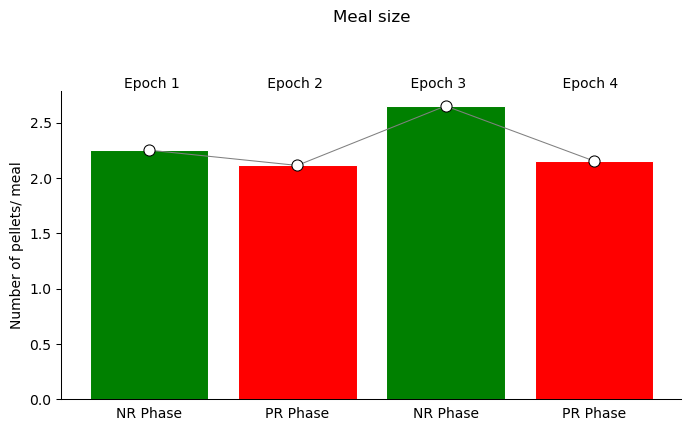

In [34]:
#this cell plots meal size of only Protein restricted mice in 4 epochs NR, PR,NR,PR


EXP_Pellets = ff.loc[ff["order"] == 2]
# CTL_Pellets= ff.loc[ff["order"] == 1]



EXP_Pellets_E1_NR = EXP_Pellets.loc[EXP_Pellets["epoch"] == "E1", ["meal_size"]].mean()

# CTL_Pellets_E1_NR = CTL_Pellets.loc[CTL_Pellets["epoch"] == "E1", ["n_pellets"]].mean()

EXP_Pellets_E2_PR = EXP_Pellets.loc[EXP_Pellets["epoch"] == "E2", ["meal_size"]].mean()

# CTL_Pellets_E2_NR = CTL_Pellets.loc[CTL_Pellets["epoch"] == "E2", ["n_pellets"]].mean()

EXP_Pellets_E3_NR = EXP_Pellets.loc[EXP_Pellets["epoch"] == "E3", ["meal_size"]].mean()

# CTL_Pellets_E3_NR = CTL_Pellets.loc[CTL_Pellets["epoch"] == "E3", ["n_pellets"]].mean()

EXP_Pellets_E4_PR = EXP_Pellets.loc[EXP_Pellets["epoch"] == "E4", ["meal_size"]].mean()

# CTL_Pellets_E4_NR = CTL_Pellets.loc[CTL_Pellets["epoch"] == "E4", ["n_pellets"]].mean()

# def Average (lst):
#     return sum(lst)/len(lst)


f, ax = plt.subplots(figsize= (8, 4))
_, _, barlist, _ = tp.barscatter([EXP_Pellets_E1_NR,EXP_Pellets_E2_PR,EXP_Pellets_E3_NR,EXP_Pellets_E4_PR], ax=ax, paired=True,linewuidth =1, groupwidth = 0.70,
barfacecolor_option="individual", baredgecolor= ["white"], barfacecolor=["green", "red","green", "red"],
barlabels = ["NR Phase","PR Phase","NR Phase","PR Phase"] )
ax.set_title("Meal size", pad= 50)






secax = ax.secondary_xaxis('top', color = "black" )
secax.set_xlabel( "Epoch 1                    Epoch 2                    Epoch 3                      Epoch 4", labelpad= -14.5)
secax.tick_params(axis='x', colors='white') 
secax.spines['top'].set_color('white')
ax.set_ylabel("Number of pellets/ meal",fontsize = 10)

# ax.axes.secondary_xaxis.set_ticklabels([])
# # secax.yticks([])
# plt.show()
# # secax.set_axis_off()
# for side in ['top','right','bottom','left']:
#     ax.spines[side].set_visible(True)
# secax.tick_params(axis='both',which='both',labelbottom=False,bottom=False,left=False)
# secax.set_yticks([min(y),max(y)]) 

C:\ProgramData\Anaconda3\lib\site-packages\trompy\barscatter.py:304: UserWarning: linewuidth is not a functional keyword argument. Check spelling or barscatter version.
  warnings.warn("{} is not a functional keyword argument. Check spelling or barscatter version.".format(key))


Text(0, 0.5, 'Number of meals / day')

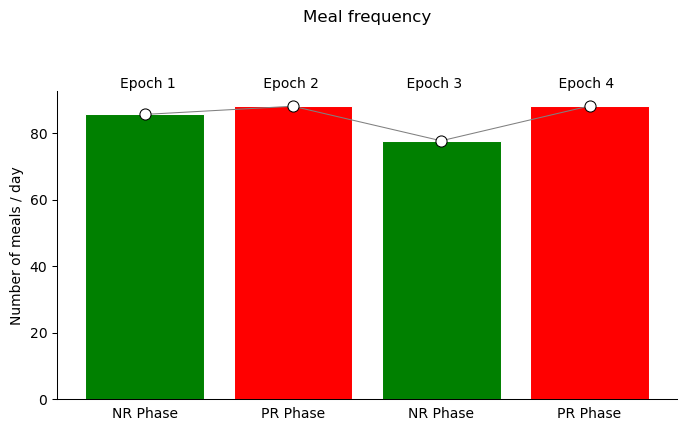

In [35]:
#this cell plots meal frequency of only Protein restricted mice in 4 epochs NR, PR,NR,PR


EXP_Pellets = ff.loc[ff["order"] == 2]
# CTL_Pellets= ff.loc[ff["order"] == 1]



EXP_Pellets_E1_NR = EXP_Pellets.loc[EXP_Pellets["epoch"] == "E1", ["meal_freq"]].mean()

# CTL_Pellets_E1_NR = CTL_Pellets.loc[CTL_Pellets["epoch"] == "E1", ["n_pellets"]].mean()

EXP_Pellets_E2_PR = EXP_Pellets.loc[EXP_Pellets["epoch"] == "E2", ["meal_freq"]].mean()

# CTL_Pellets_E2_NR = CTL_Pellets.loc[CTL_Pellets["epoch"] == "E2", ["n_pellets"]].mean()

EXP_Pellets_E3_NR = EXP_Pellets.loc[EXP_Pellets["epoch"] == "E3", ["meal_freq"]].mean()

# CTL_Pellets_E3_NR = CTL_Pellets.loc[CTL_Pellets["epoch"] == "E3", ["n_pellets"]].mean()

EXP_Pellets_E4_PR = EXP_Pellets.loc[EXP_Pellets["epoch"] == "E4", ["meal_freq"]].mean()

# CTL_Pellets_E4_NR = CTL_Pellets.loc[CTL_Pellets["epoch"] == "E4", ["n_pellets"]].mean()

# def Average (lst):
#     return sum(lst)/len(lst)


f, ax = plt.subplots(figsize= (8, 4))
_, _, barlist, _ = tp.barscatter([EXP_Pellets_E1_NR,EXP_Pellets_E2_PR,EXP_Pellets_E3_NR,EXP_Pellets_E4_PR], ax=ax, paired=True,linewuidth =1, groupwidth = 0.70,
barfacecolor_option="individual", baredgecolor= ["white"], barfacecolor=["green", "red","green", "red"],
barlabels = ["NR Phase","PR Phase","NR Phase","PR Phase"] )
ax.set_title("Meal frequency", pad= 50)






secax = ax.secondary_xaxis('top', color = "black" )
secax.set_xlabel( "Epoch 1                    Epoch 2                    Epoch 3                      Epoch 4", labelpad= -14.5)
secax.tick_params(axis='x', colors='white') 
secax.spines['top'].set_color('white')
ax.set_ylabel("Number of meals / day",fontsize = 10)

# ax.axes.secondary_xaxis.set_ticklabels([])
# # secax.yticks([])
# plt.show()
# # secax.set_axis_off()
# for side in ['top','right','bottom','left']:
#     ax.spines[side].set_visible(True)
# secax.tick_params(axis='both',which='both',labelbottom=False,bottom=False,left=False)
# secax.set_yticks([min(y),max(y)]) 

In [37]:
# get all IPIs for distribution histogram

all_ipis = []
for key, data in ff_dict.items():
#     print(key, len(data["pellets"]))
    all_ipis.append(data["pellets"].dropna().clip(1))
    
all_ipis = pd.concat(all_ipis)


# get all IPIs for distribution histogram

ipis_ALL = []
NR_IPIS = []
PR_IPIS = []
for key, data in ff_dict.items():
        if data ["diet"] == "NR":
            NR_IPIS.append(data["pellets"].dropna().clip(1))
        elif  data ["diet"] == "PR":
            PR_IPIS.append(data["pellets"].dropna().clip(1))
    

NR_IPIS = pd.concat(NR_IPIS)
PR_IPIS = pd.concat(PR_IPIS)
ipis_ALL= pd.concat([PR_IPIS, NR_IPIS] )

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


68218

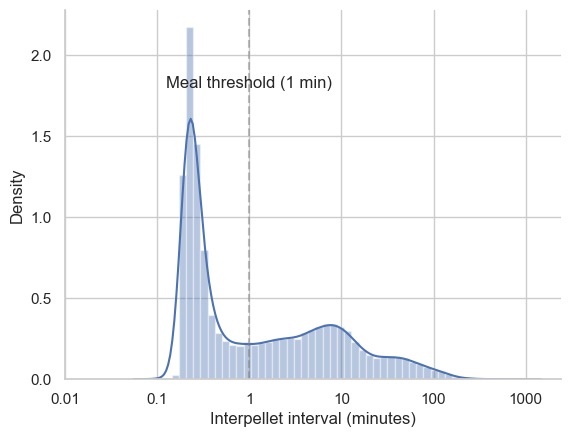

In [38]:
trans_ipis_ALL = [ipi for ipi in np.log10(ipis_ALL/60) if np.isfinite(ipi)]

f, ax = plt.subplots()
data = sns.distplot(trans_ipis_ALL)
ax.set_xlabel("Interpellet interval (minutes)")
ax.set_xticks([-2, -1, 0, 1, 2, 3], labels=["0.01", "0.1", "1", "10", "100", "1000"])

ax.axvline(0, linestyle="--", color="grey", alpha=0.5)
ax.text(0,1.8, "Meal threshold (1 min)", ha="center")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

#f.savefig("..\\results\\ipi_ff.png")
len(trans_ipis_ALL)

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


52548

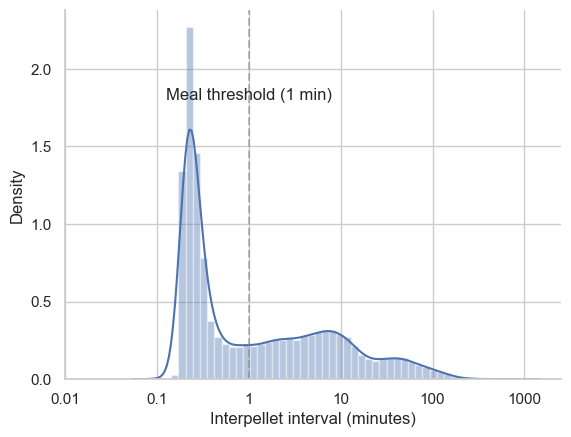

In [43]:
trans_ipisNR = [ipi for ipi in np.log10(NR_IPIS/60) if np.isfinite(ipi)]

f, ax = plt.subplots()
data = sns.distplot(trans_ipisNR)
ax.set_xlabel("Interpellet interval (minutes)")
ax.set_xticks([-2, -1, 0, 1, 2, 3], labels=["0.01", "0.1", "1", "10", "100", "1000"])

ax.axvline(0, linestyle="--", color="grey", alpha=0.5)
ax.text(0,1.8, "Meal threshold (1 min)", ha="center")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

#f.savefig("..\\results\\ipi_ff.png")

len(trans_ipisNR)

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


15670

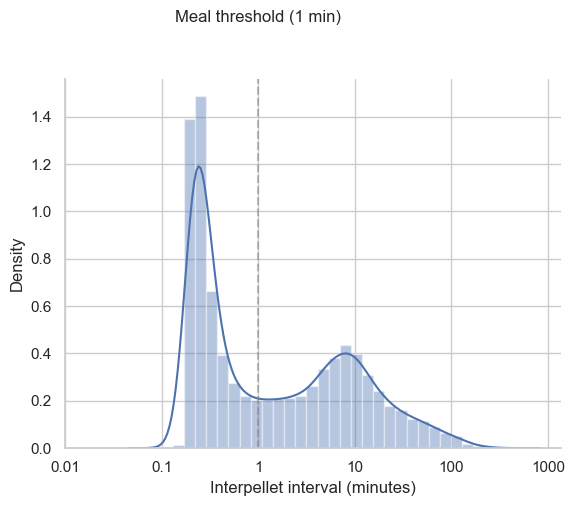

In [40]:
trans_ipisPR = [ipi for ipi in np.log10(PR_IPIS/60) if np.isfinite(ipi)]

f, ax = plt.subplots()
data = sns.distplot(trans_ipisPR)
ax.set_xlabel("Interpellet interval (minutes)")
ax.set_xticks([-2, -1, 0, 1, 2, 3], labels=["0.01", "0.1", "1", "10", "100", "1000"])


ax.axvline(0, linestyle="--", color="grey", alpha=0.5)
ax.text(0,1.8, "Meal threshold (1 min)", ha="center")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

#f.savefig("..\\results\\ipi_ff.png")
len(trans_ipisPR)

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


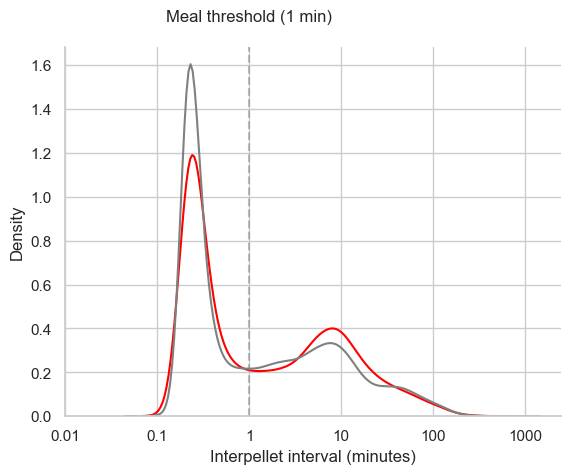

In [56]:
#converge PR and NR KDE
trans_ipisPR = [ipi for ipi in np.log10(PR_IPIS/60) if np.isfinite(ipi)]
trans_ipisNR = [ipi for ipi in np.log10(NR_IPIS/60) if np.isfinite(ipi)]
trans_ipisALL = [ipi for ipi in np.log10(all_ipis/60) if np.isfinite(ipi)]
f, ax = plt.subplots()
data = sns.distplot(trans_ipisPR, color= "red", hist = False, kde=True )
ax.set_xlabel("Interpellet interval (minutes)")
ax.set_xticks([-2, -1, 0, 1, 2, 3], labels=["0.01", "0.1", "1", "10", "100", "1000"])

# data = sns.distplot(trans_ipisNR, color = "green", hist = False )
# ax.set_xlabel("Interpellet interval (minutes)")
# ax.set_xticks([-2, -1, 0, 1, 2, 3], labels=["0.01", "0.1", "1", "10", "100", "1000"])

data = sns.distplot(trans_ipisALL, color = "grey", hist = False , kde = True)
ax.set_xlabel("Interpellet interval (minutes)")
ax.set_xticks([-2, -1, 0, 1, 2, 3], labels=["0.01", "0.1", "1", "10", "100", "1000"])


ax.axvline(0, linestyle="--", color="grey", alpha=0.5)
ax.text(0,1.8, "Meal threshold (1 min)", ha="center")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

#f.savefig("..\\results\\ipi_ff.png")



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


['grey']
Cannot flatten list. Maybe is in the wrong format. Returning empty list.
['grey']
Cannot flatten list. Maybe is in the wrong format. Returning empty list.


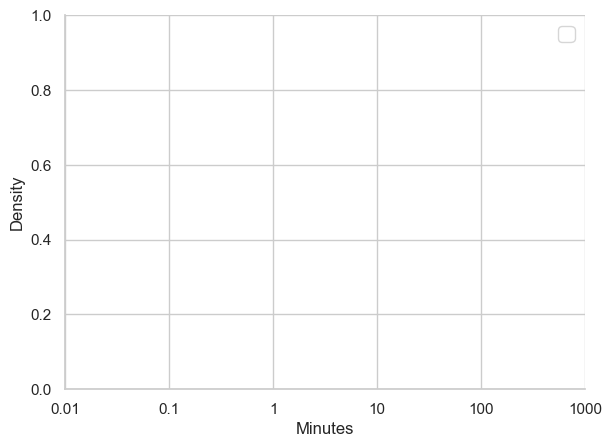

In [76]:
def EPOCH(data, ax=[], colors=[], fill=False, labels=[], linestyle="-", **kwargs):
    if ax == []:
        f, ax = plt.subplots()

    if len(colors) != len(data):
        colors = ["grey"] * len(data)
    print(colors)

    if len(labels) != len(data):
        labels = [str(n) for n in range(len(data))]

    for idx, group in enumerate(data):

        y = tp.flatten_list(group)
        y = [np.log10(val*60) for val in y if val > 0]
            
        sns.kdeplot(y, ax=ax,
                    color=colors[idx],
                    fill=fill,
                    label=labels[idx],
                    linestyle=linestyle)

    ax.set_ylabel('Density',fontsize = 12)
    ax.set_xlabel('Minutes',fontsize = 12)

    ax.set_xticks(range(-2,4))
    ax.set_xticklabels([10**num for num in range(-2,4)])

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)


f, ax = plt.subplots(figsize = (8,5.5), gridspec_kw= {"left":0.25,"bottom": 0.2})

EPOCH([trans_ipisPR],
       colors=["green", "red"],
       labels=["NRPR - NR pellets"],
       linestyle="-",
       fill=True,
       ax=ax)

EPOCH([trans_ipisPR],
       colors=["xkcd:kelly green", "pink"],
       labels=["PRNR - PR pellets"],
       linestyle="--",
       fill=True,
       ax=ax)
                           

ax.legend(fontsize = 15)

In [55]:
plt.subplots??

Signature:
plt.subplots(
    nrows=1,
    ncols=1,
    *,
    sharex=False,
    sharey=False,
    squeeze=True,
    subplot_kw=None,
    gridspec_kw=None,
    **fig_kw,
)
Source:   
def subplots(nrows=1, ncols=1, *, sharex=False, sharey=False, squeeze=True,
             subplot_kw=None, gridspec_kw=None, **fig_kw):
    """
    Create a figure and a set of subplots.

    This utility wrapper makes it convenient to create common layouts of
    subplots, including the enclosing figure object, in a single call.

    Parameters
    ----------
    nrows, ncols : int, default: 1
        Number of rows/columns of the subplot grid.

    sharex, sharey : bool or {'none', 'all', 'row', 'col'}, default: False
        Controls sharing of properties among x (*sharex*) or y (*sharey*)
        axes:

        - True or 'all': x- or y-axis will be shared among all subplots.
        - False or 'none': each subplot x- or y-axis will be independent.
        - 'row': each subplot row will share an x- or y-a

NameError: name 'interpellet_interval_plot' is not defined

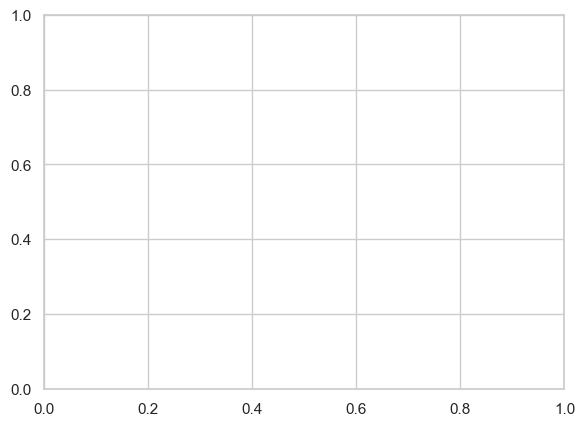

In [71]:
f, ax = plt.subplots(figsize = (8,5.5), gridspec_kw= {"left":0.25,"bottom": 0.2})

interpellet_interval_plot([IPIs_m_nrpr_nr, IPIs_m_nrpr_pr],
                           colors=["green", "red"],
                           labels=["NRPR - NR pellets", "NRPR - PR pellets"],
                           linestyle="-",
                           fill=True,
                           ax=ax)

interpellet_interval_plot([IPIs_m_prnr_nr, IPIs_m_prnr_pr],
                           colors=["xkcd:kelly green", "pink"],
                           labels=["PRNR - NR pellets", "PRNR - PR pellets"],
                           linestyle="--",
                           fill=True,
                           ax=ax)

ax.legend(fontsize = 15)

#f.savefig(figfolder + "interpelletintervalmale.pdf")


# figfolder = r"C:\Users\hta031\OneDrive - UiT Office 365\Documents\People\Hamid\Educational Component\Midway_Evaluation\MIDWAY_PRESENTATION\FIGS\\"
# f.savefig(figfolder + "Kernel_all_groups.tif")

In [211]:
xls = pd.ExcelFile(r"C:\Users\hta031\Github\FEDPROTEINPRO\METAFILE FEDXC DATA SHEETS.xls")
dfmeta= pd.read_excel(xls,"METAFILE")


In [212]:
dfmeta

,fedfile,mouse,diet,mode,sex,order,epoch
0,FED001_091022_00.CSV,FEDXC01,NR,FF,M,2,E1
1,FED001_091922_00_MERGED.CSV,FEDXC01,PR,FF,M,2,E2
2,FED001_092622_00.CSV,FEDXC01,NR,FF,M,2,E3
3,FED001_100322_00.CSV,FEDXC01,PR,FF,M,2,E4
4,FED002_091022_00.CSV,FEDXC02,NR,FF,M,2,E1
5,FED002_091922_00.CSV,FEDXC02,PR,FF,M,2,E2
6,FED002_092622_00.CSV,FEDXC02,NR,FF,M,2,E3
7,FED002_100322_00.CSV,FEDXC02,PR,FF,M,2,E4
8,FED003_091022_00.CSV,FEDXC03,NR,FF,M,2,E1
9,FED003_091922_00.CSV,FEDXC03,PR,FF,M,2,E2
